In [1]:
import torch # PyTorch의 모든 기능을 기본적으로 가지고 있는 모듈(라이브러리)
import torch.nn as nn # Neural Networks (nn): 네트워크 모델 그 자체
import torch.optim as optim # 경사 하강법을 제공

import numpy as np # NumPy를 매번 다 쓰기 귀찮으니까, np라고 줄여서 씀(전세계 통용)
import matplotlib.pyplot as plt # Matplotlib 그래프 시각화 라이브러리(막대 그래프, 직선 그래프 등)

In [2]:
device = torch.device("cuda")

(100,)
(100,)


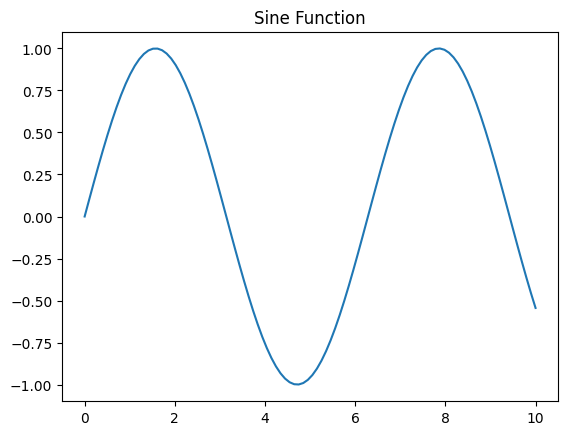

In [6]:
data_size = 100

# 0부터 10(대충 3파이)까지 100개의 포인트를 만들기
data_x = np.linspace(0, 10, data_size) # 0부터 10까지 100개의 포인트 설정
print(data_x.shape)
data_y = np.sin(data_x) # 각 포인트에 대한 sine() 값 계산
print(data_y.shape)

plt.title("Sine Function")
plt.plot(data_x, data_y)
plt.show()

In [7]:
sequence_size = 5 # 5 (입력 길이)
train_size = data_size - sequence_size # 95 (총 데이터 개수 - 입력 길이)

train_X = []
train_Y = []

for i in range(0, train_size):
    train_X.append(data_y[i:i + sequence_size]) # 앞의 5개가 주어졌을 때
    train_Y.append(data_y[i + sequence_size]) # 다음 값을 맞추는 문제
# train_X    train_Y
#   [0:5] →    5
#   [1:6] →    6
#   [2:7] →    7
#   [3:8] →    8

train_X = np.array(train_X)
train_Y = np.array(train_Y)

# [시퀀스의 개수, 시퀀스 크기]
print(train_X.shape)
print(train_Y.shape)

train_X = torch.from_numpy(train_X)
train_Y = torch.from_numpy(train_Y)

# PyTorch에서 사용할 수 있는 형태로 변환 후에 GPU로 옮기기
train_X = torch.transpose(train_X, 0, 1).unsqueeze(2).float().to(device)
train_Y = train_Y.unsqueeze(1).float().to(device)

print(train_X.shape) # [시퀀스 크기, 시퀀스 개수, 입력(1)]
print(train_Y.shape) # [시퀀스 개수, 정답(1)]

(95, 5)
(95,)
torch.Size([5, 95, 1])
torch.Size([95, 1])


In [8]:
input_dim = 1 # 입력 차원(x)
output_dim = 1 # 출력 차원(y)
hidden_dim = 1000 # 임베딩 차원 emd_dim 이라고 많이 표현

In [9]:
# nn.Module PyTorch 네트워크 그 자체
#   __init__(): 학습할 가중치를 정의하는 부분
#   forward(): 데이터 x가 들어왔을 때, 예측 결과인 y를 내뱉는 함수

class RNN(nn.Module):
    # input_dim: 입력 차원(x) = 1차원
    # output_dim: 출력 차원(y) = 1차원
    # hidden_dim: 임의로 설정한 1000차원
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(RNN, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.w_xh = nn.Linear(self.input_dim, self.hidden_dim) # 1 → 1000 (1 X 1000 가중치)
        self.w_hh = nn.Linear(self.hidden_dim, self.hidden_dim) # 1000 → 1000 (1000 X 1000 가중치)
        self.w_hy = nn.Linear(self.hidden_dim, self.output_dim) # 1000 → 1 (1000 X 1000 가중치)

    def forward(self, x, h):
        h = nn.Tanh()(self.w_xh(x) + self.w_hh(h))
        y = self.w_hy(h)
        return y, h

In [10]:
# (학습된) 현재 모델의 출력을 확인
def show(rnn):
    rnn.eval()
    predictions = []

    # 현재 예제에서는 [학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(train_size, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    # train_X: [5 X 95 X 1]
    for x in train_X:
        # x_1: [0, 95 X 1] = [batch_size, 1]
        # x_2: [1, 95 X 1] = [batch_size, 1]
        # x_3: [2, 95 X 1] = [batch_size, 1]
        # x_4: [3, 95 X 1] = [batch_size, 1]
        # x_5: [4, 95 X 1] = [batch_size, 1]
        # 학습 데이터 개수가 적기 때문에, (batch_size = 전체 데이터 개수)
        y_pred, h = rnn(x, h)

    plt.title("Prediction Result")
    plt.plot(data_x[sequence_size:], data_y[sequence_size:]) # 정답(Real)
    plt.plot(data_x[sequence_size:], y_pred.view(-1).cpu().detach().numpy()) # 우리 모델 예측 결과(Predicted)
    plt.legend(["Real", "Predicted"])
    plt.show()

[ Training Start ]


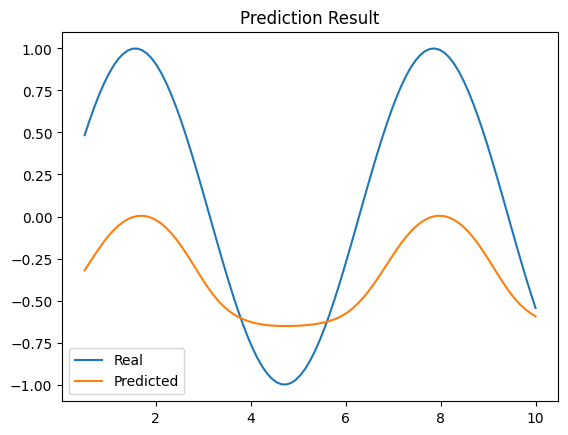

[1000/10000] loss = 2.1730844309786335e-05


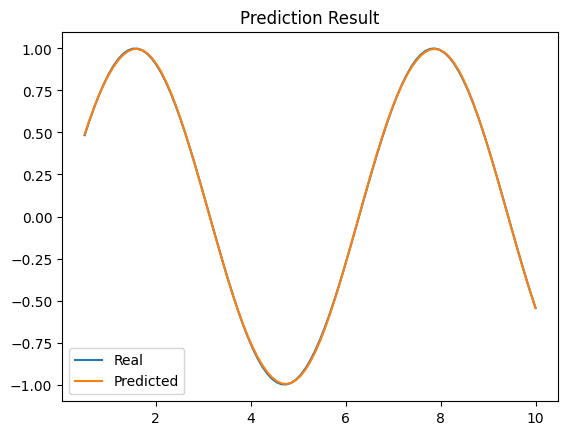

[2000/10000] loss = 5.601345947070513e-06


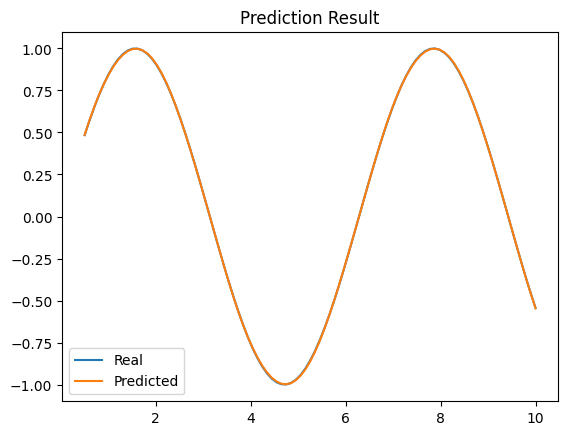

[3000/10000] loss = 3.818089226115262e-06


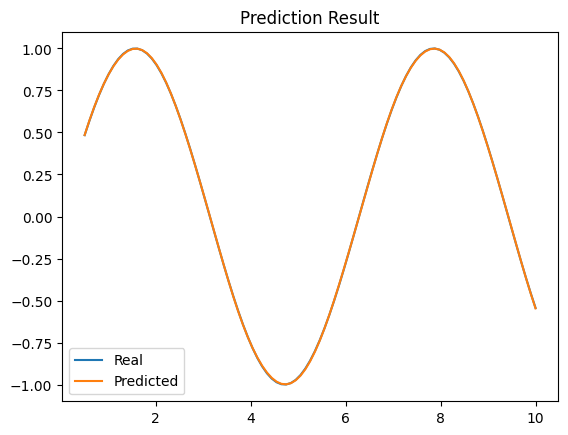

[4000/10000] loss = 3.2963353078230284e-06


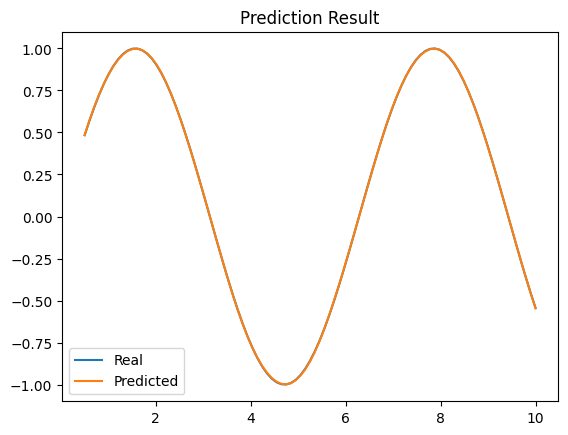

[5000/10000] loss = 2.947989059975953e-06


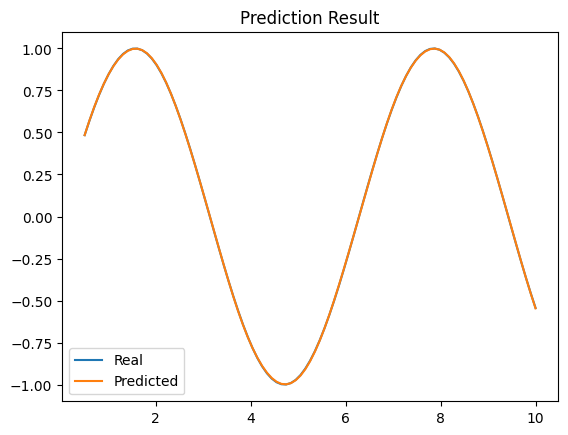

[6000/10000] loss = 2.6694583539210726e-06


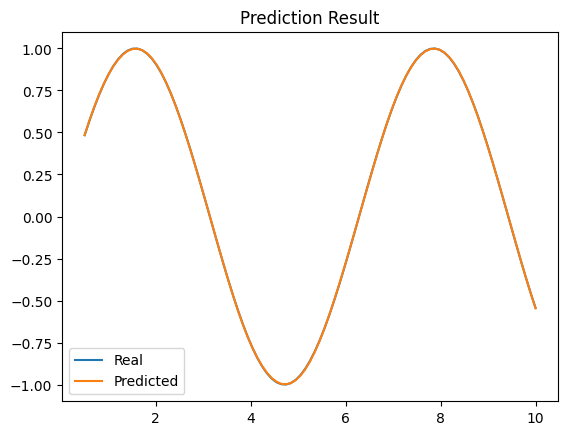

[7000/10000] loss = 2.438247747704736e-06


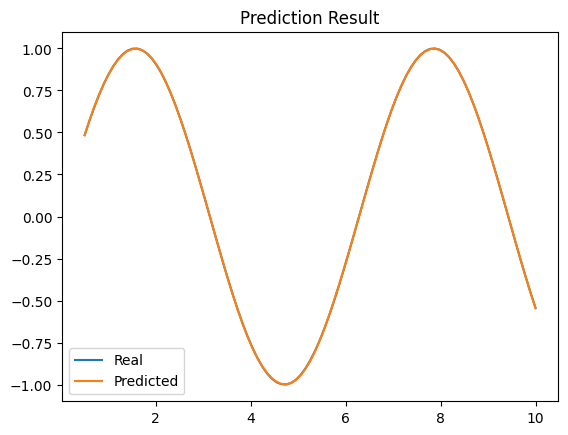

[8000/10000] loss = 2.2420283585233847e-06


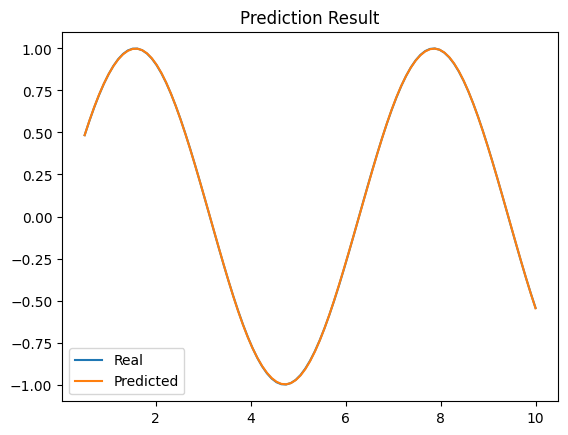

[9000/10000] loss = 2.0726572529383702e-06


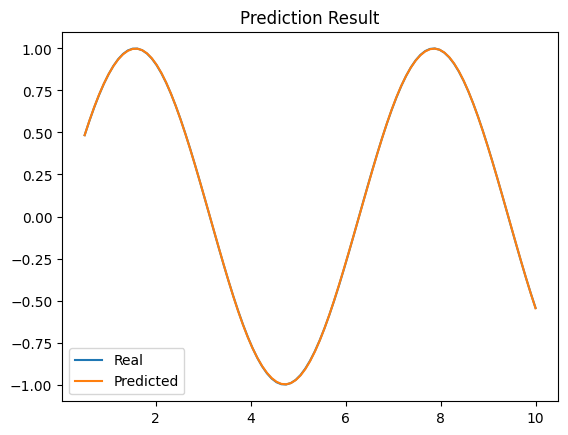

[10000/10000] loss = 1.9241247173340525e-06


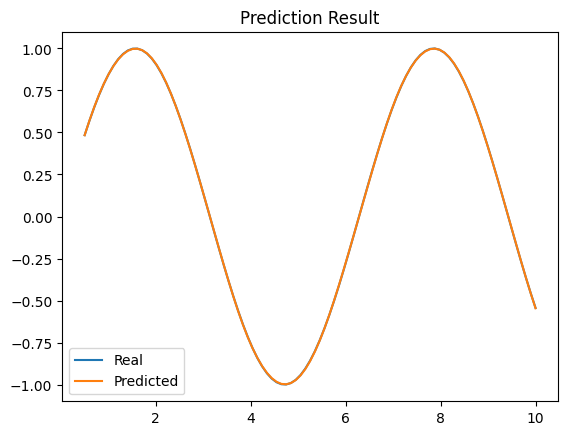

In [11]:
rnn = RNN(input_dim, output_dim, hidden_dim).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005, momentum=0.9)

print("[ Training Start ]")
show(rnn)

epoch = 10000

for i in range(epoch):
    rnn.train()
    rnn.zero_grad()
    optimizer.zero_grad()

    # 현재 예제에서는 [학습 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(train_size, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    # train_X: [5 X 95 X 1]
    for x in train_X:
        # x_1: [0, 95 X 1] = [batch_size, 1]
        # x_2: [1, 95 X 1] = [batch_size, 1]
        # x_3: [2, 95 X 1] = [batch_size, 1]
        # x_4: [3, 95 X 1] = [batch_size, 1]
        # x_5: [4, 95 X 1] = [batch_size, 1]
        # 학습 데이터 개수가 적기 때문에, (batch_size = 전체 데이터 개수)
        y_pred, h = rnn(x, h)

    # 손실(loss) 값을 계산하여 학습 진행
    loss = loss_fn(train_Y, y_pred)
    loss.backward()
    optimizer.step()

    if (i + 1) % 1000 == 0:
        print(f"[{i + 1}/{epoch}] loss = {loss.item()}")
        show(rnn)


In [12]:
# 평가를 위한 하나의 시퀀스 생성
test_X = train_X[:, 0, :].unsqueeze(2)
print(test_X.shape)

rnn.eval()
predictions = []

for i in range(1000):
    # 현재 예제에서는 [평가 데이터의 개수 = 배치 크기, 히든 크기]
    h = torch.zeros(1, hidden_dim).to(device)

    # 시퀀스에 포함된 데이터를 연속적으로 넣기
    for x in test_X:
        y_pred, h = rnn(x, h)

    test_X = torch.cat((test_X, y_pred.unsqueeze(0)), dim=0)[1:]
    predictions.append(y_pred.item())

torch.Size([5, 1, 1])


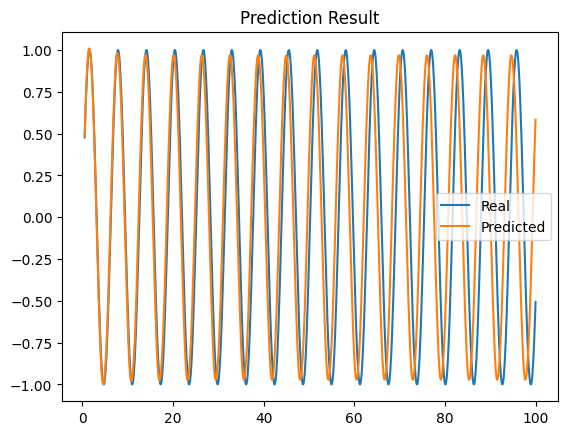

In [13]:
test_x = np.linspace(0, 100, 1000 + sequence_size)
test_y = np.sin(test_x) # 각 포인트에 대한 sine() 값 계산

plt.title("Prediction Result")
plt.plot(test_x[sequence_size:], test_y[sequence_size:])
plt.plot(test_x[sequence_size:], predictions)
plt.legend(["Real", "Predicted"])
plt.show()
